In [1]:
import ipywidgets as widgets

topo_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='topo path:',
    disabled=False
)


vtk_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='vtk path',
    disabled=False
)

display(topo_path)
display(vtk_path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='topo path:', placeho…

Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='vtk path', placehold…

In [26]:
%matplotlib inline
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from scipy.optimize import minimize
from scipy.spatial import distance
import ipyvolume as ipv
import numpy as np
from skimage import io, filters
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy.ma as ma

pt_cloud_cyl = np.load(topo_path.value)

reader = vtk.vtkXMLPolyDataReader()
reader.SetFileName(vtk_path.value)
reader.Update()



In [27]:
import numpy.ma as ma

def interpolate(pt_cloud,x,y):
    triang = tri.Triangulation(pt_cloud[:,1], pt_cloud[:,2])
    interpolator = tri.LinearTriInterpolator(triang, pt_cloud[:,0])
    return interpolator(Xi, Yi)    

norm_pt_cloud_na = np.copy(pt_cloud_cyl)
norm_pt_cloud_na[:,0] = norm_pt_cloud_na[:,0] - 5.8/2

z_res = 200
theta_res = 300
r_res = 5

r_delta_max = np.max(norm_pt_cloud_na[:,0])
r_delta_min = np.min(norm_pt_cloud_na[:,0])
zz = np.linspace(-1.00,1.00,z_res)
Xi, Yi = np.meshgrid(np.linspace(0,2*np.pi,theta_res),zz)
r = interpolate(norm_pt_cloud_na,Xi, Yi)


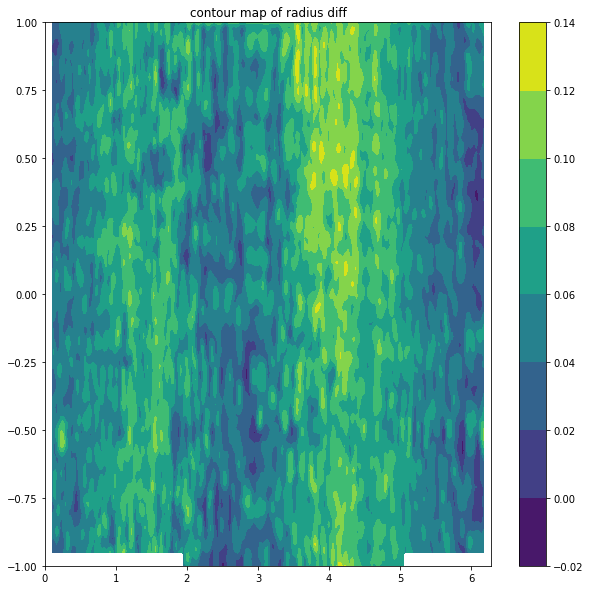

In [28]:
from skimage.filters import gaussian
smoothed = gaussian(r,sigma = 1)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title('contour map of radius diff')
cf = ax.contourf(Xi, Yi,smoothed)
fig.colorbar(cf)
plt.show()

In [29]:
dist_s = np.zeros((z_res,r_res))
bin_edge = np.linspace(r_delta_min,r_delta_max,r_res+1)
for i in range(z_res):
    bined, bin_edge=np.histogram(smoothed[i,:],bins=bin_edge)
    dist_s[i] = bined


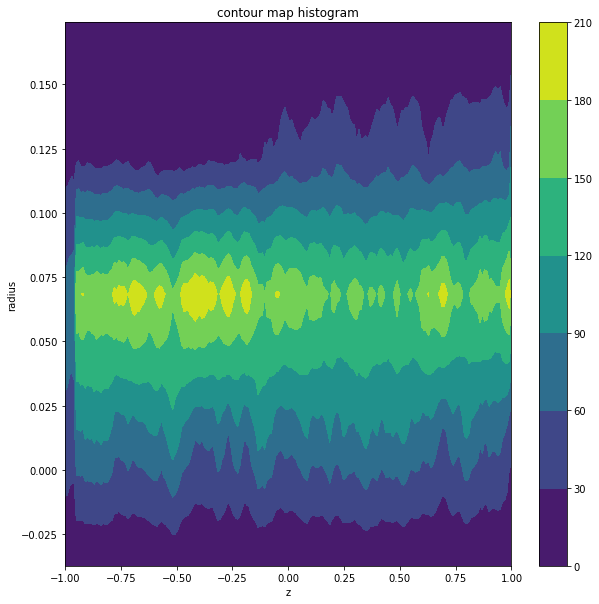

In [30]:
fig,ax = plt.subplots(figsize=(10,10))
Zi,bini = np.meshgrid(zz,np.linspace(r_delta_min,r_delta_max,r_res))
cf = ax.contourf(Zi,bini,dist_s.T)
fig.colorbar(cf)
ax.set_title('contour map histogram')
ax.set_xlabel("z")
ax.set_ylabel("radius")
plt.show()

In [47]:
pore_net = dsa.WrapDataObject(reader.GetOutput())

equiv_dia = pore_net.PointData['network | net_01 | properties | pore.equivalent_diameter']
pt_cloud_pt = pore_net.GetPoints()

ipv.quickscatter(pt_cloud_pt[:,0], pt_cloud_pt[:,1], pt_cloud_pt[:,2], size=equiv_dia/10, marker="sphere")
ipv.show()

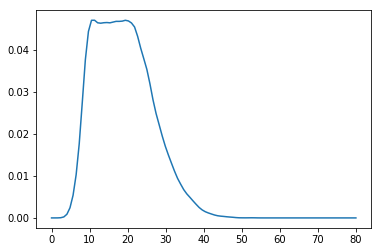

In [122]:
from sklearn.neighbors import KernelDensity

x_plot = np.linspace(0,80,100)
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(equiv_dia.reshape(-1,1))
log_den = kde.score_samples(x_plot.reshape(-1,1))

fig, ax = plt.subplots()
ax.plot(x_plot, np.exp(log_den))
plt.show()

In [109]:
total = 0
dens_ls = np.exp(log_den)
d90_loc = 0

for i in range(dens_ls.shape[0]):
    density = dens_ls[i]
    if(total < 0.90):
        total += density
    else:
        d90_loc = i
        break
    

In [110]:
print('D90: {}'.format(x_plot[d90_loc]))

D90: 24.242424242424242


In [123]:
dist_p = np.zeros((z_res,r_res))

min_z = np.min(pt_cloud_pt[:,2])
max_z = np.max(pt_cloud_pt[:,2])

z_range = np.linspace(min_z,max_z,z_res+1)

inds = np.digitize(pt_cloud_pt[:,2],z_range)

d_min = np.min(equiv_dia)
d_max = np.max(equiv_dia)

particle_bins = np.linspace(d_min,d_max,r_res+1)

for i in range(1,z_res+1):
    mask = inds == i
    subset = equiv_dia[mask]
    bined, bin_edge = np.histogram(subset,bins=particle_bins)
    dist_p[i-1] = bined
    

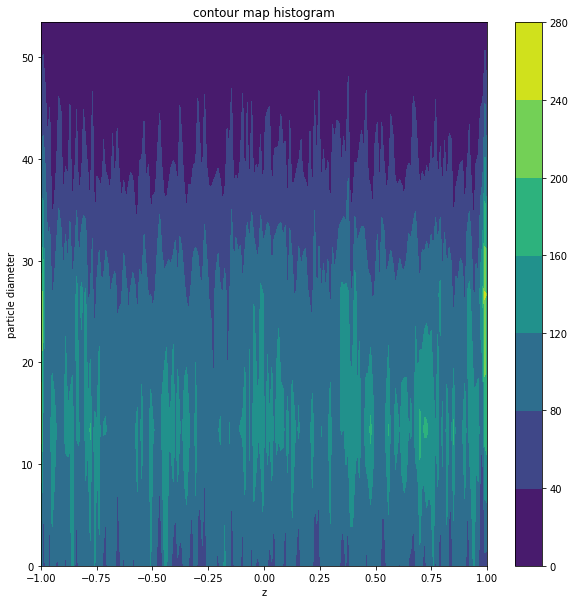

In [120]:
fig,ax = plt.subplots(figsize=(10,10))
Zi,bini = np.meshgrid(zz,np.linspace(0,biggest_particle,r_res))
cf = ax.contourf(Zi,bini,dist_p.T)
fig.colorbar(cf)
ax.set_title('contour map histogram')
ax.set_xlabel("z")
ax.set_ylabel("particle diameter")
plt.show()